In [ ]:
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
df = pd.read_excel(r"train.xlsx").drop(["Unnamed: 0", "№ брони"], axis = 1)
mask = df['Дата отмены'].isna()
df['Отмена'] = 0
df['Отмена'][mask==False] = 1
df.drop(columns=["Дата отмены", "Статус брони"], inplace=True)

<ipython-input-3-bf22bd16bba7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Отмена'][mask==False] = 1


In [ ]:
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
#df['Источник'] = lbl.fit_transform(df['Источник'])
#df['Категория номера'] = lbl.fit_transform(df['Категория номера'])
#df['Способ оплаты'] = lbl.fit_transform(df['Способ оплаты'])
#df.drop(columns=["Дата бронирования", "Заезд", "Выезд"], inplace=True)

In [ ]:
Y = df['Отмена']
X = df.drop(columns=["Отмена"])
#X['Error_Status'] = 0
#X.loc[X[((X['Номеров'] > 1)& (~X['Категория номера'].str.contains("\n")))].index, "Error_Status"] = 1

In [ ]:
from sklearn.model_selection import KFold
from catboost import Pool, cv, CatBoostClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
data1 = X["Дата бронирования"]
data2 = X["Заезд"]
data3 = X["Выезд"]
X.drop(columns=["Дата бронирования", "Заезд", "Выезд"], inplace=True)
X['data1_day_week'] = data1.dt.day_of_week
X['data2_day_week'] = data2.dt.day_of_week
X['data3_day_week'] = data3.dt.day_of_week

X['data1_day_year'] = data1.dt.day_of_year
X['data2_day_year'] = data2.dt.day_of_year
X['data3_day_year'] = data3.dt.day_of_year

X['data1_m'] = data1.dt.month
X['data2_m'] = data2.dt.month
X['data3_m'] = data3.dt.month


In [ ]:
X.head()

,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Ночей,Источник,Категория номера,Гостей,Гостиница,data1_day_week,data2_day_week,data3_day_week,data1_day_year,data2_day_year,data3_day_year,data1_m,data2_m,data3_m
0,1,25700.0,0,Внешняя система оплаты,3,Яндекс.Путешествия,Номер «Стандарт»,2,1,3,4,0,110,118,121,4,4,5
1,1,24800.0,12400,Отложенная электронная оплата: Банк Россия (ба...,2,Официальный сайт,Номер «Стандарт»,2,1,5,0,2,169,192,194,6,7,7
2,1,25800.0,12900,Банк. карта: Банк Россия (банк. карта),2,Официальный сайт,Номер «Студия»,2,4,0,6,1,318,338,340,11,12,12
3,1,10500.0,0,Внешняя система оплаты (С предоплатой),1,Bronevik.com(new),Номер «Стандарт»,1,3,4,0,1,251,261,262,9,9,9
4,1,28690.0,28690,Система быстрых платежей: Эквайринг ComfortBoo...,2,Официальный сайт,Номер «Люкс»,4,1,5,0,2,140,149,151,5,5,5


In [ ]:
pool = Pool(X, Y, cat_features=["Источник", "Категория номера", "Способ оплаты"])
params = {
    "loss_function": "Logloss",
    'eval_metric': 'AUC',
    "max_depth":5,
    "n_estimators":1500
}
cv_ = cv(pool, params, fold_count=4, plot = True, verbose = 0)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/4]

bestTest = 0.8435719166
bestIteration = 1093

Training on fold [1/4]

bestTest = 0.8503027033
bestIteration = 1344

Training on fold [2/4]

bestTest = 0.8441901525
bestIteration = 831

Training on fold [3/4]

bestTest = 0.8459485958
bestIteration = 1192



In [ ]:
import optuna
from catboost import CatBoostClassifier
cat_features = ['Способ оплаты', 'Источник', 'Категория номера']

def objective(trial):
    # Подбор гиперпараметров
    iterations = trial.suggest_int('iterations', 500, 1500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.4)
    depth = trial.suggest_int('depth', 4, 12)
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 3, 15)
    random_strength = trial.suggest_int('random_strength', 1, 10)

    model = CatBoostClassifier(iterations=iterations,
                               learning_rate=learning_rate,
                               depth=depth,
                               random_seed=42,
                               cat_features=cat_features,
                               l2_leaf_reg = l2_leaf_reg,
                               random_strength=random_strength,
                               verbose=0)

    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)

    # Оценка модели
    return roc_auc_score(y_test, y_pred_proba[:, 1])

# Запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Вывод наилучших гиперпараметров
print("Best hyperparameters: ", study.best_params)
print("Best AUC: ", study.best_value)

In [ ]:
cv_['test-AUC-mean'].max()

0.8452223551651028

In [ ]:
model = CatBoostClassifier(**params)

In [ ]:
model.fit(X, Y, cat_features=["Источник", "Категория номера", "Способ оплаты"])

Learning rate set to 0.028634
0:	total: 22.1ms	remaining: 33.1s
1:	total: 44.3ms	remaining: 33.1s
2:	total: 63.4ms	remaining: 31.6s
3:	total: 82.9ms	remaining: 31s
4:	total: 101ms	remaining: 30.1s
5:	total: 120ms	remaining: 29.8s
6:	total: 139ms	remaining: 29.6s
7:	total: 158ms	remaining: 29.5s
8:	total: 178ms	remaining: 29.4s
9:	total: 200ms	remaining: 29.8s
10:	total: 218ms	remaining: 29.5s
11:	total: 234ms	remaining: 29s
12:	total: 251ms	remaining: 28.8s
13:	total: 268ms	remaining: 28.4s
14:	total: 288ms	remaining: 28.5s
15:	total: 306ms	remaining: 28.4s
16:	total: 326ms	remaining: 28.5s
17:	total: 346ms	remaining: 28.5s
18:	total: 364ms	remaining: 28.3s
19:	total: 384ms	remaining: 28.4s
20:	total: 406ms	remaining: 28.6s
21:	total: 425ms	remaining: 28.6s
22:	total: 443ms	remaining: 28.4s
23:	total: 461ms	remaining: 28.3s
24:	total: 484ms	remaining: 28.5s
25:	total: 502ms	remaining: 28.5s
26:	total: 527ms	remaining: 28.8s
27:	total: 548ms	remaining: 28.8s
28:	total: 566ms	remaining: 

In [ ]:
pred = model.predict_proba(X)[:, 1]

In [ ]:
roc_auc_score(Y, pred)

0.8991993641846361

In [ ]:
import shap

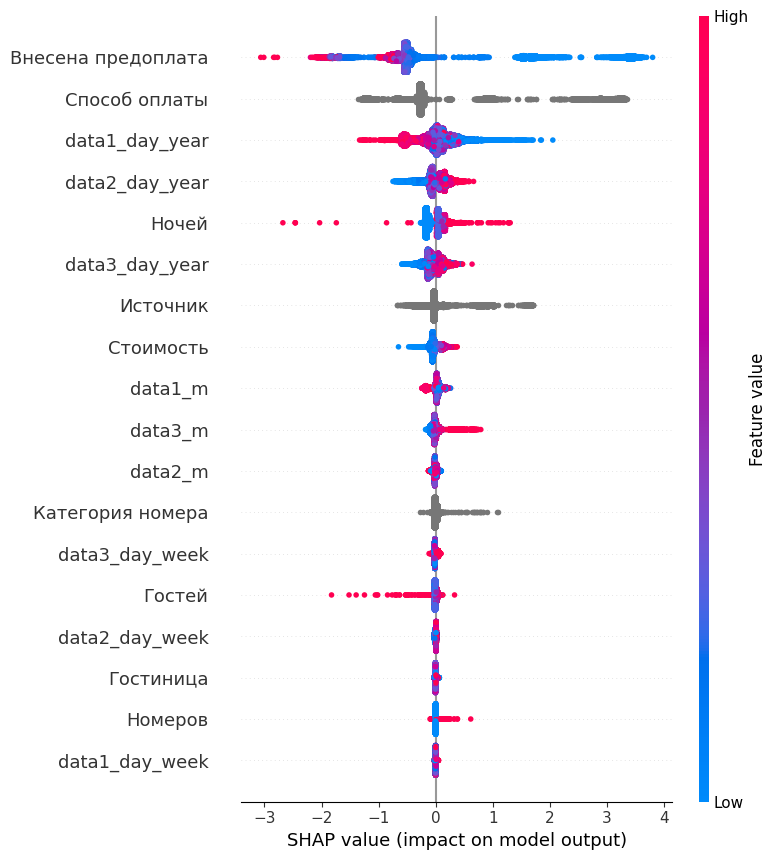

In [ ]:
shap.initjs()

# Create a TreeExplainer object for the 'model' (assumes 'model' is a tree-based model like a Random Forest or XGBoost)
ex = shap.TreeExplainer(model)

# Calculate SHAP values for the 'X_test' data using the TreeExplainer
shap_values = ex.shap_values(X)

# Generate a summary plot to visualize the impact of features on model predictions
shap.summary_plot(shap_values, X)

In [ ]:
test = pd.read_excel(r"C:\MyProgram\MyCode\Хак\test.xlsx").drop(["Unnamed: 0", "№ брони"], axis = 1)

In [ ]:
data1 = test["Дата бронирования"]
data2 = test["Заезд"]
data3 = test["Выезд"]
test.drop(columns=["Дата бронирования", "Заезд", "Выезд"], inplace=True)
test['data1_day_week'] = data1.dt.day_of_week
test['data2_day_week'] = data2.dt.day_of_week
test['data3_day_week'] = data3.dt.day_of_week

test['data1_day_year'] = data1.dt.day_of_year
test['data2_day_year'] = data2.dt.day_of_year
test['data3_day_year'] = data3.dt.day_of_year

test['data1_m'] = data1.dt.month
test['data2_m'] = data2.dt.month
test['data3_m'] = data3.dt.month

In [ ]:
pred = model.predict_proba(test)[:, 1]

In [ ]:
pd.DataFrame(pred).to_csv('1.csv', index=False)